## User-Based Collaborative Filtering.

Elias Ejo, 12/10/2022

## Step 1: Import Python Libraries

In [99]:
# Data processing
import pandas as pd
import numpy as np

# Visualization
import matplotlib.pyplot as plt
import seaborn as sns

# Similarity
from sklearn.metrics.pairwise import cosine_similarity

# Label encoder 
from sklearn import preprocessing

# Surprise builder and analyzer
from surprise import reader as sr
from surprise import dataset as sd
from surprise import KNNBasic
from surprise import BaselineOnly
from surprise import accuracy
from surprise.model_selection import cross_validate
from surprise.model_selection import train_test_split

%matplotlib inline

## Step 2 : Loading and Exploratory Data Analysis on BX-Books dataset

### 2.1: Load the dataset

In [100]:
# Read BX-Book dataset from file into book_df
book_df = pd.read_csv("BX-Books.csv", low_memory=False, encoding='latin-1')

book_df is a variable which will store the data read by the csv file.


In [101]:
# Print first 5 rows of the dataset
book_df.head()

,isbn,book_title,book_author,year_of_publication,publisher
0,195153448,Classical Mythology,Mark P. O. Morford,2002,Oxford University Press
1,2005018,Clara Callan,Richard Bruce Wright,2001,HarperFlamingo Canada
2,60973129,Decision in Normandy,Carlo D'Este,1991,HarperPerennial
3,374157065,Flu: The Story of the Great Influenza Pandemic...,Gina Bari Kolata,1999,Farrar Straus Giroux
4,393045218,The Mummies of Urumchi,E. J. W. Barber,1999,W. W. Norton &amp; Company


In [102]:
# Print last 5 rows of the dataset
book_df.tail()

,isbn,book_title,book_author,year_of_publication,publisher
271374,440400988,There's a Bat in Bunk Five,Paula Danziger,1988,Random House Childrens Pub (Mm)
271375,525447644,From One to One Hundred,Teri Sloat,1991,Dutton Books
271376,006008667X,Lily Dale : The True Story of the Town that Ta...,Christine Wicker,2004,HarperSanFrancisco
271377,192126040,Republic (World's Classics),Plato,1996,Oxford University Press
271378,767409752,A Guided Tour of Rene Descartes' Meditations o...,Christopher Biffle,2000,McGraw-Hill Humanities/Social Sciences/Languages


### 2.2: Understand the dataset

In [103]:
# Check the size of the dataset
book_df.shape

(271379, 5)

Observation:
* The dataset has 271,379 rows and 5 columns

In [104]:
# Print detail information about the dataframe
book_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 271379 entries, 0 to 271378
Data columns (total 5 columns):
 #   Column               Non-Null Count   Dtype 
---  ------               --------------   ----- 
 0   isbn                 271379 non-null  object
 1   book_title           271379 non-null  object
 2   book_author          271378 non-null  object
 3   year_of_publication  271379 non-null  object
 4   publisher            271377 non-null  object
dtypes: object(5)
memory usage: 10.4+ MB


Observation: 
* There are 5 columns in the dataframe.


In [105]:
# Data types of different column values
book_df.dtypes

isbn                   object
book_title             object
book_author            object
year_of_publication    object
publisher              object
dtype: object

Observations:
* We can see that all of our data columns are of type object, indicating that they contains strings

In [106]:
# Identify variables with null values
count = book_df.isnull().sum().sort_values(ascending=False)
percent = (book_df.isnull().mean()*100).sort_values(ascending=False)

missing_df = pd.concat([count, percent], axis=1,keys=['Missed-Count', 'Missed-Percent'])

# Print out missed value count and percentile of columns
missing_df[missing_df['Missed-Count'] > 0]

,Missed-Count,Missed-Percent
publisher,2,0.000737
book_author,1,0.000368


Observation:
* There are two vraibles that have missing values. Publisher has 2 and Book-Author has 1 missed value

In [107]:
# Check for duplicate book in the dataset
book_df[book_df['isbn'].duplicated()]

,isbn,book_title,book_author,year_of_publication,publisher


Obsrvation:
* No duplicate book in the dataset

### 2.3: Missing Value Treatment

In [108]:
# Replace the missing values with unknown
book_df['publisher'].fillna('unknown',inplace=True)
book_df['book_author'].fillna('unknown',inplace=True)

Observation:
* Both the Publisher and Book-Auther missed values replaced by 'unknown'

In [109]:
# Let's again check the missing value count after the replacment
print(f"Publisher missed value count = {book_df['publisher'].isna().sum()}")
print(f"Book-Author missed value count = {book_df['book_author'].isna().sum()}")

Publisher missed value count = 0
Book-Author missed value count = 0


Observation
* It verifies the logical correctness of the data points

### 2.4: Data cleaning

In [110]:
# Remove unwanted characher from book title
book_df["book_title"] = book_df["book_title"].str.replace("\s+", " ", regex=True)
# book_df["clean_title"] = book_df["clean_title"].str.lower()

### 2.5 Extracting the Important Features

In [111]:
# Print the name of the columns present in the df dataframe
book_df.columns

Index(['isbn', 'book_title', 'book_author', 'year_of_publication',
       'publisher'],
      dtype='object')

In [112]:
# Drop unnecessary columns present in the df dataframe
book_df = book_df[['isbn', 'book_title']]

In [113]:
# Check the size of the finla dataset
book_df.shape

(271379, 2)

## Step 3 : Loading and Exploratory Data Analysis on BX-Users dataset

### 3.1: Load the dataset

In [114]:
# Load BX-Users dataset from file into user_df
user_df = pd.read_csv("BX-Users.csv",low_memory=False, encoding="latin-1")

user_df is a variable which will store the data read by the csv file.

In [115]:
# Print first 5 rows of the dataset
user_df.head()

,user_id,Location,Age
0,1,"nyc, new york, usa",NaN
1,2,"stockton, california, usa",18.0
2,3,"moscow, yukon territory, russia",NaN
3,4,"porto, v.n.gaia, portugal",17.0
4,5,"farnborough, hants, united kingdom",NaN


In [116]:
# Print last 5 rows of the dataset
user_df.tail()

,user_id,Location,Age
278854,278854,"portland, oregon, usa",NaN
278855,278855,"tacoma, washington, united kingdom",50.0
278856,278856,"brampton, ontario, canada",NaN
278857,278857,"knoxville, tennessee, usa",NaN
278858,278858,"dublin, n/a, ireland",NaN


### 3.2: Understand the dataset

In [117]:
# Check the size of the dataset
user_df.shape

(278859, 3)

Observation:
* The dataset has 278,859 rows and 3 columns

In [118]:
# Printing detail information of the dataset
user_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 278859 entries, 0 to 278858
Data columns (total 3 columns):
 #   Column    Non-Null Count   Dtype  
---  ------    --------------   -----  
 0   user_id   278859 non-null  object 
 1   Location  278858 non-null  object 
 2   Age       168096 non-null  float64
dtypes: float64(1), object(2)
memory usage: 6.4+ MB


Observation: 
* There are 3 columns in the dataframe.

In [119]:
# Data types of different column values
user_df.dtypes

user_id      object
Location     object
Age         float64
dtype: object

Observations:
* We can see that 2 of our data columns are of type object. They are therefore strings. Age is of the type float64, which implies it have decimalsin in it.

In [120]:
# Identify variables with null values
count = user_df.isnull().sum().sort_values(ascending=False)
percent = (user_df.isnull().mean()*100).sort_values(ascending=False)

missing_df = pd.concat([count, percent], axis=1,keys=['Missed-Count', 'Missed-Percent'])

# Print out missed value count and percentile of columns
missing_df[missing_df['Missed-Count'] > 0]

,Missed-Count,Missed-Percent
Age,110763,39.720074
Location,1,0.000359


Observation:
* There are two vraibles that have missing values. Location has 1 and Age has 110,763 missed value

In [121]:
# Check for duplicate user in the dataset
user_df[user_df['user_id'].duplicated()]

,user_id,Location,Age


Obsrvation:
* No duplicate user in the dataset

### 3.3: Data Conversion

In [122]:
# Convertr User Id and Age column into integer
user_df["user_id"] = pd.to_numeric(user_df['user_id'], errors='coerce').round(0).astype('Int64', errors='ignore')
user_df["Age"] = user_df['Age'].round(0).astype('Int32', errors='ignore')

In [123]:
# Check data types of column values after conversion
user_df.dtypes

user_id      Int64
Location    object
Age          Int32
dtype: object

Observation:
* User Id column data type has been chnaged from onject into Int64
* Age column data type has been chnaged from object into Int32

### 3.4: Missing Value Treatment

In [124]:
# Drop rows that all thier column values are null
user_df.dropna(how='all', inplace=True)

In [125]:
# Calculate the mean of the ages
age_mean = round(user_df['Age'].mean())

In [126]:
# Replace Age null value with mean of the column
user_df['Age'].fillna(age_mean, inplace=True)

In [127]:
# After replacing check the number of column null values
user_df.isnull().sum()

user_id     0
Location    0
Age         0
dtype: int64

### 3.5: Custom Fnctions That Used in Adding New Feature

In [128]:
# Check the string contains any digit
def contains_number(str):
    ''' Checks the passed parameter contains a digit or not. 
        And retruns boolen'''
    return any(c.isdigit() for c in str)
    
# Custom funtion to extract a country name
def country_name(cstr):
    ''' Accepts comma separted string. By spliting into array and some cleaning retruns the last item of the array'''
    cstr = cstr.replace('\n/a\"','')
    cstr = cstr.replace('n/a','') 
    cstr = cstr.replace('\"','') 
    cstr = cstr.replace('/','') 
    cstr = cstr.replace('\\','') 
    cstr = cstr.replace('-','') 

    #  la argentina
    lst = cstr.split(',')
    name = lst[len(lst) -1].strip()
    
    if len(name) <= 1:
        return np.NaN

    if contains_number(name):
        return np.NaN

    return name

### 3.6: Imputting and Adding New Feature

In [129]:
# Impute age less than 14 or greter than 95 by mean of the ages
rindex = user_df[(user_df['Age'] < 14) | (user_df['Age'] > 95)].index
user_df.loc[rindex, 'Age'] = age_mean

In [130]:
# Create a separate column for country name
user_df['Country'] = pd.DataFrame([country_name(x) for x in user_df['Location'] ])

In [131]:
# Check the size after adding new column
user_df.shape

(278858, 4)

Observation:
* You can see that after new column added the column size of the dataset has increased by 1

In [132]:
# Replace null value of the new column with usa
user_df['Country'].fillna('usa', inplace=True)

In [133]:
# Replace the below country name with usa
# ['u.s. virgin islands', 'u.s. of a.', 'u.s.a.', 'u.s>', 'u.s.a!', 'u.s.a>', 'good old u.s.a.']
matches = [match for match in user_df['Country'].unique().astype('str') if "u.s" in match]

user_df['Country'].replace(matches, 'usa', inplace=True)

### 3.7: Extracting the Important Features

In [134]:
# Print the name of the columns present in the df dataframe
user_df.columns

Index(['user_id', 'Location', 'Age', 'Country'], dtype='object')

In [135]:
# Drop unnecessary columns present in the dataframe
user_df = user_df[['user_id','Country']]

In [136]:
# Check the size of the finla dataset
user_df.shape

(278858, 2)

### 3.8: Countplot for The New Feature 'Country'

<AxesSubplot:xlabel='Country'>

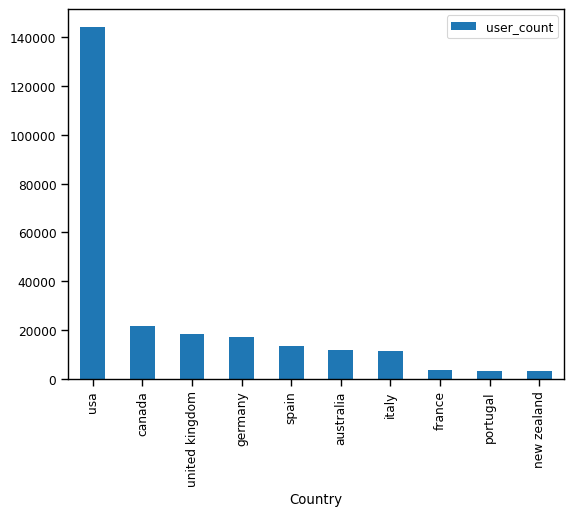

In [137]:
data =user_df.groupby('Country').size().reset_index(name='user_count').sort_values(['user_count'], ascending=False).head(10)

data.plot(kind='bar', x='Country', y='user_count')


Observation:
* In the above graph, we can see most of the user are from USA

## Step 4 : Loading and Exploratory Data Analysis on BX-Ratings dataset

### 4.1: Load the dataset

In [138]:
# Load BX-Book-Ratings dataset from file into book_rating_df
book_rating_df = pd.read_csv("BX-Book-Ratings.csv",encoding='latin-1')

In [139]:
# Print first 5 rows of the dataset
book_rating_df.head()

,user_id,isbn,rating
0,276725,034545104X,0
1,276726,155061224,5
2,276727,446520802,0
3,276729,052165615X,3
4,276729,521795028,6


In [140]:
# Print last 5 rows of the dataset
book_rating_df.tail()

,user_id,isbn,rating
1048570,250764,451410777,0
1048571,250764,452264464,8
1048572,250764,048623715X,0
1048573,250764,486256588,0
1048574,250764,515069434,0


### 4.2: Understand the dataset

In [141]:
# Print the size of the dataset
book_rating_df.shape

(1048575, 3)

Observation:
* The dataset has 1,048,575 rows and 3 columns

In [142]:
# Print detail information of the dataset
book_rating_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1048575 entries, 0 to 1048574
Data columns (total 3 columns):
 #   Column   Non-Null Count    Dtype 
---  ------   --------------    ----- 
 0   user_id  1048575 non-null  int64 
 1   isbn     1048575 non-null  object
 2   rating   1048575 non-null  int64 
dtypes: int64(2), object(1)
memory usage: 24.0+ MB


Observation: 
* There are 3 variables in the book_rating_df dataframe. 
* user_id and rating are of data type int64 and isbn is type of object. The type of isbn implies it contain string. 

In [143]:
# Identify variables with null values
count = book_rating_df.isnull().sum().sort_values(ascending=False)
percent = (book_rating_df.isnull().mean()*100).sort_values(ascending=False)

missing_df = pd.concat([count, percent], axis=1,keys=['Missed-Count', 'Missed-Percent'])

# Print out missed value count and percentile of columns
missing_df[missing_df['Missed-Count'] > 0]

,Missed-Count,Missed-Percent


Observation:
* There are no null values present in the book_rating_df dataframe.

In [144]:
# Check for duplicate user rate in the dataset
book_rating_df.duplicated(['user_id','isbn']).value_counts()

False    1048306
True         269
dtype: int64

Observation:
* As we can see, there are 269 duplicates user ratings. This needs to be deleted

In [145]:
# Print unique values count of each variables

# declare a dictionary variable
nunique_val = {}

nunique_val["Users"] = book_rating_df['user_id'].nunique()
nunique_val["Books"] = book_rating_df['isbn'].nunique()
nunique_val["Ratings"] = book_rating_df['rating'].nunique()

# Create dataframe from nunique_val dictionary
nunique_val_df = pd.DataFrame(nunique_val.items(),columns=["Variable Name", "Number of Unique Count"])
# align text display of 'Variable Name' column to left
nunique_val_df.style.set_properties(subset=["Variable Name"], **{'text-align': 'left'})

,Variable Name,Number of Unique Count
0,Users,95513
1,Books,322102
2,Ratings,11


Observation:
* As we can see, there are 95,513 unique users, 322,102 unique books and the rating has 11 unique values.

In [146]:
# Print unique values of the rating
print('The rating hasunique ratings are', sorted(book_rating_df['rating'].unique()))

The rating hasunique ratings are [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10]


Observation:
* The rating has ten unique values from 0 to 10.

### 4.3: Drop duplicate

In [147]:
# Drop rows with duplicate user_id and isbn but keep the rows with the max rating value 
book_rating_df = book_rating_df.sort_values('rating', ascending=False).drop_duplicates(subset=['user_id','isbn']).sort_index()

In [148]:
# Check after droping duplicat rows
book_rating_df.duplicated(['user_id','isbn']).value_counts()

False    1048306
dtype: int64

Observation:
* As we can see, there are no more duplicate rows in book_rating_df dataframe.

### 4.4: Filter rows to makes calculation manageable

We need to filter the book-rating and keep only those with over 0 rating and those which received more than 10 ratings for the analysis. 

This makes calculation manageable in our machine. 

In [149]:
# Keep book rating over 0
book_rating_df = book_rating_df[book_rating_df['rating'] > 0]

In [150]:
# Check the size of the dataset after rows with 0 rating has removed
book_rating_df.shape

(397139, 3)

Observation:
* After applying the filter, we can see that there are 397,139 book-rating left.

In [151]:
# Aggregate by book and get count and mean
agg_rating_by_isbn_df = book_rating_df.groupby('isbn').agg({'rating':['count','mean']}).reset_index()
agg_rating_by_isbn_df.columns = ['isbn','rating_count','rating_mean']

In [152]:
# Keep books which received more than 10 ratings
agg_rating_GT10_count_df = agg_rating_by_isbn_df[(agg_rating_by_isbn_df.rating_count > 10)]

In [153]:
# Check the size of the dataset
agg_rating_GT10_count_df.size

13332

Observation:
* After applying the filter(rating count >10), we can see that there are 13,332 book-rating left.

In [154]:
# Merge the book-rating with a dataframe which contains books that has recived more that 10 ratings
book_rating_GT10_count_df = pd.merge(book_rating_df, agg_rating_GT10_count_df['isbn'], on='isbn', how='inner').sort_values(['user_id']).reset_index(drop=True)

In [155]:
# Aggrigate users and calculate count of books they have rated
agg_user_GT2_book_count_df = book_rating_GT10_count_df.groupby('user_id').agg({'isbn':'count'}).reset_index()
agg_user_GT2_book_count_df.columns = ['user_id','user_book_count']

In [156]:
# Keeps users who rates more than 5 books
agg_user_GT2_book_count_df = agg_user_GT2_book_count_df[agg_user_GT2_book_count_df['user_book_count'] >5]
agg_user_GT2_book_count_df.shape

(4139, 2)

Observation:
* After applying the filter(user_book_count >5), we can see that there are 4,139 users who has rated more than 5 book.

### 4.5: Visualization

In [157]:
# Get top 10 rated books
top_rated_books =  agg_rating_GT10_count_df.sort_values(by='rating_count', ascending=False).head(10)
# merge the book title from book_df
top_rated_books = pd.merge(top_rated_books, book_df[['isbn', 'book_title']],on='isbn', how='inner')

<AxesSubplot:xlabel='rating_count', ylabel='book_title'>

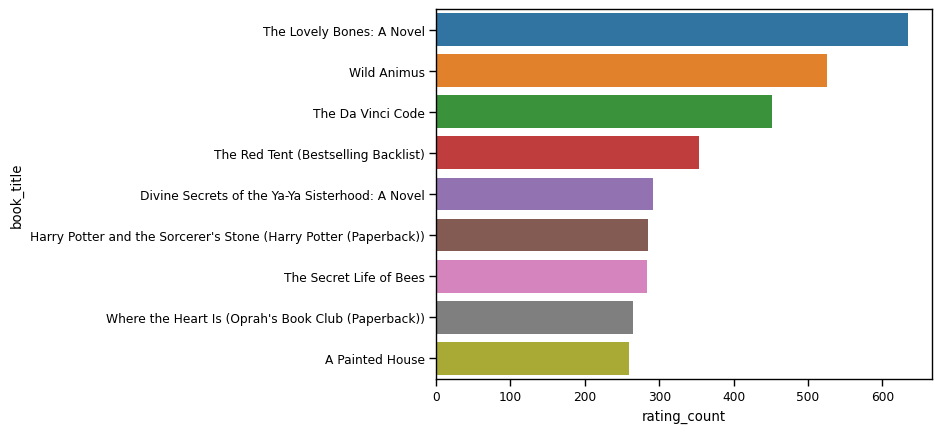

In [158]:
# Barplot for feature 'book_title'
sns.barplot(y='book_title', x='rating_count', data=top_rated_books)

<Figure size 1600x800 with 0 Axes>

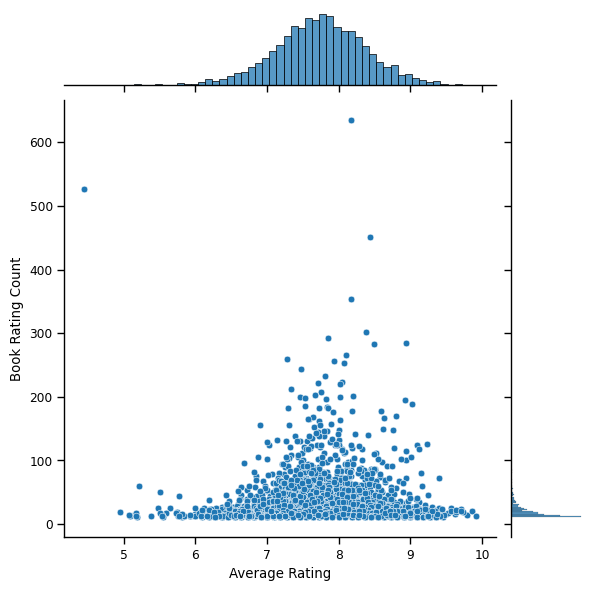

In [159]:
#Checking for any relation between them.
plt.figure(figsize=(16,8))
sns.set_context('paper')
ax = sns.jointplot(x="rating_mean",y='rating_count', kind='scatter', data= agg_rating_GT10_count_df[['rating_mean', 'rating_count']])
ax.set_axis_labels("Average Rating", "Book Rating Count")
plt.show()

### 4.6: Creating Final DataFrame

In [160]:
# Merge both dataframe book_rating_GT10_count_df, agg_user_GT2_book_count_df into single dataframe.
# Store the final dataframe inside final_book_rating_df
final_book_rating_df = pd.merge(book_rating_GT10_count_df, agg_user_GT2_book_count_df[['user_id']], on=['user_id'], how='inner')

In [161]:
# Print first 5 rows of the final dataset
final_book_rating_df.head()

,user_id,isbn,rating
0,243,155874262X,5
1,243,316601950,9
2,243,60977493,7
3,243,316776963,9
4,243,044023722X,7


In [162]:
# Print the size of the final dataset
final_book_rating_df.shape

(70947, 3)

In [163]:
# Number of users
print('The final book ratings dataset has', final_book_rating_df['user_id'].nunique(), 'unique users')

# Number of books
print('The final book ratings dataset has', final_book_rating_df['isbn'].nunique(), 'unique isbn')

# Number of ratings
print('The final boook ratings dataset has', final_book_rating_df['rating'].nunique(), 'unique ratings')

# List of unique ratings
print('The unique ratings are', sorted(final_book_rating_df['rating'].unique()))

The final book ratings dataset has 4139 unique users
The final book ratings dataset has 4427 unique isbn
The final boook ratings dataset has 10 unique ratings
The unique ratings are [1, 2, 3, 4, 5, 6, 7, 8, 9, 10]


### 4.7: Create Ordered Integer Identifiers For User and Isbn

In [164]:
# Create new ordered integer identifiers from user_id by using category codes
final_book_rating_df["user_index"] = final_book_rating_df["user_id"].astype("category").cat.codes

In [165]:
# Create new ordered integer identifiers from isbn by using category codes
final_book_rating_df["book_index"] = final_book_rating_df["isbn"].astype("category").cat.codes

In [166]:
# Print first 5 rows of the final dataset after adding two integer identifiers columns
final_book_rating_df.head()

,user_id,isbn,rating,user_index,book_index
0,243,155874262X,5,0,546
1,243,316601950,9,0,835
2,243,60977493,7,0,3269
3,243,316776963,9,0,859
4,243,044023722X,7,0,185


In [167]:
# Aggrigate book-index and user-index
final_book_rating_df.agg({'book_index':['min', 'max', 'count'], 'user_index':['min', 'max', 'count']})

,book_index,user_index
min,0,0
max,4426,4138
count,70947,70947


Observation:
* user-index has orderd value from 0 upto 4426
* book-index has orderd value from 0 upto 4138 

In [168]:
final_book_rating_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 70947 entries, 0 to 70946
Data columns (total 5 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   user_id     70947 non-null  int64 
 1   isbn        70947 non-null  object
 2   rating      70947 non-null  int64 
 3   user_index  70947 non-null  int16 
 4   book_index  70947 non-null  int16 
dtypes: int16(2), int64(2), object(1)
memory usage: 2.4+ MB


Observation: 
* There are 5 variables in the final_book_rating_df dataframe. 
* There are 70,947 rows of data

## Step 5: Create User-Book Matrix

In [169]:
# Create user book matrix
user_book_matrix = final_book_rating_df.pivot_table(index='user_index', columns='book_index', values='rating')

In [170]:
# Print the first 5 rows of the matrix
user_book_matrix.head()

book_index,0,1,2,3,4,5,6,7,8,9,...,4417,4418,4419,4420,4421,4422,4423,4424,4425,4426
user_index,,,,,,,,,,,,,,,,,,,,,
0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,NaN,NaN,NaN,NaN,NaN,NaN,9.0,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


Observation:
* The dataset transformed into a matrix format. The rows of the matrix are users and the columns of the matrix are books
* The value of the matrix is the user rating of the book if the user has rated of the book else  it set to null.

## Step 6: Data Normalization

In [171]:
# Normalize user-item matrix
normalize_user_book_matrix = user_book_matrix.subtract(user_book_matrix.mean(axis=1), axis = 'rows')
normalize_user_book_matrix.head()

book_index,0,1,2,3,4,5,6,7,8,9,...,4417,4418,4419,4420,4421,4422,4423,4424,4425,4426
user_index,,,,,,,,,,,,,,,,,,,,,
0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,NaN,NaN,NaN,NaN,NaN,NaN,1.0,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


Observation:
* The rating normalized by extracting the average rating of each user.
* After normalization, the book with a rating less than the user's average rating get a negative value,
* And the book with a rating more than the user's average rating get a positive value.

## Step 7: Calculate Similarity Score

In [172]:
# Create user similarity matrix using cosine-similarity
user_similarity = cosine_similarity(normalize_user_book_matrix.fillna(0))

In [173]:
# the size of the matrix
user_similarity.shape

(4139, 4139)

In [174]:
# Print the first 5 rows of the matrix
user_similarity[0:6,:]

array([[1.        , 0.22579308, 0.        , ..., 0.        , 0.00889827,
        0.        ],
       [0.22579308, 1.        , 0.        , ..., 0.        , 0.        ,
        0.        ],
       [0.        , 0.        , 1.        , ..., 0.        , 0.        ,
        0.04475728],
       [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ],
       [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ],
       [0.        , 0.        , 0.04508222, ..., 0.        , 0.        ,
        0.        ]])

Observation:
* We used a cosine similarity method to measure similarities.

In [175]:
# Pick a user ID
picked_user_index = 0

# Top 15 similar users
top_similar = 10

# A minium similarity threashold
min_threshold = 0.3

Let's use user_index 0 as an example to illustrate how to find similar users. 

In [176]:
# Get top N similar users plus 1 becouse the picked user included in the result 
n_similar = ((top_similar + 1) * -1)

# Find the top N score
similarity_score = np.sort(user_similarity[user_similarity[picked_user_index]>min_threshold][picked_user_index])[n_similar:]

# Find the top N score user index
similar_user_indices = np.argsort(user_similarity[user_similarity[picked_user_index]>min_threshold][picked_user_index])[n_similar:]

# Create a dataframe to store top N similar user with thier score
similar_users_df = pd.DataFrame(data=similarity_score, index=similar_user_indices, columns=['score'])

# Drop the picked user index 0 from the similar user list 
similar_users = similar_users_df.drop(index=picked_user_index)

# Exclude the picked user index 0 from the similar user indices
similar_user_indices = similar_user_indices[similar_user_indices != picked_user_index]

In [177]:
# Print the similar users for user 0
similar_users

,score
3491,0.185683
2522,0.198083
2726,0.217285
1,0.225793
1840,0.226051
1564,0.238542
2473,0.258229
1141,0.270405
2047,0.297062
943,0.393939


## Step 8: Narrow Down Similarity Dataset

In step 8, we will narrow down the similar user-book dataset by doing the following:
1. Remove the books that have been read by the picked user(user index 0 in this example).
2. Keep only the books that similar users have read.

In [178]:
# Books that the picked user has read
picked_user_read = user_book_matrix[user_book_matrix.index == picked_user_index] 
picked_user_read = picked_user_read.loc[:, (picked_user_read.notnull()).any(axis=0)]

picked_user_read

book_index,185,546,835,859,880,1254,1599,1824,2195,2277,2360,3066,3218,3269,4102
user_index,,,,,,,,,,,,,,,
0,7.0,5.0,9.0,9.0,7.0,10.0,7.0,9.0,9.0,6.0,6.0,8.0,10.0,7.0,5.0


In [179]:
# Books that similar users have read.
similar_users_read_df = user_book_matrix[user_book_matrix.index.isin(similar_user_indices)]

# Remove the books that none of the similar users have read
similar_users_read_df = similar_users_read_df.loc[:, (similar_users_read_df.notnull()).any(axis=0)]

In [180]:
# Remove the books which have read by the picked user.
similar_users_read_df.drop(picked_user_read.columns, axis=1, inplace=True, errors='ignore')

In [181]:
# Take a look at the final narrow down dataset
similar_users_read_df

book_index,133,174,182,194,273,327,376,399,426,442,...,3676,3686,3721,3748,3895,4025,4116,4120,4159,4348
user_index,,,,,,,,,,,,,,,,,,,,,
1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,8.0,NaN
943,NaN,10.0,NaN,NaN,NaN,NaN,NaN,10.0,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,10.0,NaN,NaN,NaN,NaN
1141,NaN,NaN,NaN,NaN,7.0,NaN,NaN,NaN,NaN,NaN,...,7.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1564,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1840,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,5.0,NaN,9.0
2047,NaN,NaN,5.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,8.0,NaN,6.0,NaN,NaN,NaN,NaN,NaN
2473,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,8.0,8.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2522,NaN,NaN,NaN,NaN,NaN,7.0,7.0,NaN,NaN,NaN,...,NaN,NaN,NaN,7.0,NaN,NaN,NaN,NaN,NaN,NaN
2726,9.0,NaN,NaN,8.0,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,10.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


## Step 9: Book Recommender

In step 9, we will decide which book to recommend to the picked user(user_index 0). 
1. The recommended books are determined by the weighted average of user similarity score and book rating. 
2. The book ratings are weighted by the similarity scores, so the users with higher similarity get higher weights.
3. This code loops through books and users to get the book score.
4. Order the score from high to low and pick the top 10 book to recommend to user ID 1.

In [182]:
# A dictionary to store book scores
book_score = {}

# Loop through the book rating dataframe that similar users have read
for col in similar_users_read_df.columns:
  
  # Get the value of the rating of book col
  book_rating = similar_users_read_df[col]
  total_score = 0
  count = 0

  # Loop through similar users
  for userIndex in similar_users.index:
    # Does the book has rating
    if pd.isna(book_rating[userIndex]) == False:
      # Score is the sum of user similarity score multiply by the book rating
      score = (similar_users.loc[userIndex][0]) * book_rating[userIndex]
      total_score += score
      count +=1
  # Get the average score for the book
  book_score[col] = total_score / count

# Convert dictionary to pandas dataframe
book_score = pd.DataFrame(book_score.items(), columns=['book_index', 'book_score'])
    
# Sort the ranked book by score
ranked_book_score_df = book_score.sort_values(by='book_score', ascending=False)

In [183]:
# Get the top N recommendations
ranked_book_score_df = ranked_book_score_df.head(top_similar)

In [184]:
# Print top N recommendations
ranked_book_score_df

,book_index,book_score
41,2117,3.939394
42,2166,3.939394
78,4025,3.939394
35,1974,3.939394
65,3398,3.939394
16,695,3.939394
7,399,3.939394
37,1986,3.939394
1,174,3.939394
36,1984,2.923866


In [185]:
# Get list of isbn by book indexs
def get_book_isbn_by_indexs(book_indexs):
    '''Find books by index and returns an array of thier Isbn.'''
    book_isbns = final_book_rating_df[final_book_rating_df["book_index"].isin(book_indexs)][["isbn","book_index"]]
    book_isbns = book_isbns.drop_duplicates()

    return book_isbns

# Get an array of book title by book-isbn
def get_book_title_by_isbns(book_isbns):
    '''Find books by isbn and returns an array of thier title.'''
    book_titles = book_df[book_df["isbn"].isin(book_isbns)][['isbn', 'book_title']]

    return book_titles

In [186]:
# Get N top ranked books isbn
book_isbns = get_book_isbn_by_indexs(ranked_book_score_df['book_index'].tolist())

# Get N top ranked books title
book_titles = get_book_title_by_isbns(book_isbns['isbn'].tolist())

# Merge isbn into ranked book
user_ranked_books = pd.merge(ranked_book_score_df, book_isbns[['isbn','book_index']], on=['book_index'], how='inner')

# Merge title into ranked book
user_ranked_books = pd.merge(user_ranked_books, book_titles[['isbn', 'book_title']], on=["isbn"], how="inner" )

# Print recommende books
user_ranked_books

,book_index,book_score,isbn,book_title
0,2117,3.939394,440904196,"Are You There God? It's Me, Margaret"
1,2166,3.939394,446310786,To Kill a Mockingbird
2,4025,3.939394,743486226,Angels &amp; Demons
3,1974,3.939394,440211727,A Time to Kill
4,3398,3.939394,64400050,By the Shores of Silver Lake (Little House)
5,695,3.939394,310205719,The Purpose-Driven Life: What on Earth Am I He...
6,399,3.939394,140177396,Of Mice and Men (Penguin Great Books of the 20...
7,1986,3.939394,440214041,The Pelican Brief
8,174,3.939394,044021145X,The Firm
9,1984,2.923866,440213525,The Client


We can see that the top 10 recommended books all have score greater than 2.5 

## Step 10: Cross Validation

In [187]:
# Initialize Reader classs
reader = sr.Reader(rating_scale=(1, 10))

# To load custom dataset that store in final_book_rating_df dataframe
data = sd.Dataset.load_from_df(final_book_rating_df[["user_index", "book_index", "rating"]], reader)

In [188]:
# Split train test
trainset, testset = train_test_split(data, test_size = .25, random_state=10)

In [189]:
sim_options = {'name': 'cosine','user_based': True}
algo = KNNBasic(sim_options=sim_options)

# Train the algorithm on the trainset, and predict ratings for the testset
predictions = algo.fit(trainset).test(testset)

Computing the cosine similarity matrix...
Done computing similarity matrix.


In [190]:
# Then compute RMSE
mae = accuracy.mae(predictions)
rmse = accuracy.rmse(predictions)

MAE:  1.4808
RMSE: 1.9087


In [191]:
result = pd.DataFrame(predictions, columns=["user_index", "book_index", "base_event", 'predict_event', 'details'])
result.drop(columns = {'details'}, inplace = True)
result['erro'] = abs(result['base_event'] - result['predict_event'])
result.head()

,user_index,book_index,base_event,predict_event,erro
0,132,1955,5.0,7.359696,2.359696
1,1366,2624,9.0,7.972287,1.027713
2,640,4116,4.0,8.333333,4.333333
3,1197,2547,8.0,6.500000,1.500000
4,156,328,8.0,8.096193,0.096193
